<img align="left" src="../../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg" width="15%">
<img align="right" src="../../Supplementary_data/MGCI/FAO_logo_Blue_3lines_en.jpeg" width="50%">

#  Mountain Green Cover Index Notebook (SDG 15.4.2)

## Background

### Sustainable Development Goal 15:

Protect, restore and promote sustainable use of terrestrial ecosystems, sustainably manage forests, combat desertification, and halt and reverse land degradation and halt biodiversity loss.

### Target 15.4
By 2030, ensure the conservation of mountain ecosystems, including their biodiversity, in order to enhance their capacity to provide benefits that are essential for sustainable development.

### Indicator 15.4.2: Mountain Green Cover Index

The Mountain Green Cover Index (MGCI) is designed to measure the extent and the changes of green vegetation in mountain areas - i.e. forest, shrubs, trees, pasture land, crop land, etc. – in order to monitor progress towards the mountain target. MGCI is defined as the percentage of green cover over the total surface of the mountain region of a given country and for a given reporting year. The aim of the index is to monitor the evolution of the green cover and thus assess the status of conservation of mountain ecosystems. More information on MGCI can be found [here](https://www.fao.org/sustainable-development-goals/indicators/1542/en/).

## Description

The methodology to calculate the Mountain Green Cover index was initially developed by FAO [(De Simone et al., 2021)](https://doi.org/10.3390/ijgi10070427).

The Mountain Green Cover index is calculated using two descriptor layers of information:

1. A mountain descriptor layer: mountains can be defined with reference to a variety of
parameters, such as climate, elevation, ecology (Körner et al., 2011) (Karagulle et al., 2017). This
methodology adheres to the UNEP- WCMC mountain definition, relying in turn on the mountain
description proposed by Kapos et al. (2000).

2. A vegetation descriptor layer: The vegetation descriptor layer categorizes land cover into green
and non-green areas. Green vegetation includes both natural vegetation and vegetation resulting from
anthropic activity (e.g. crops, afforestation, etc.). Non-green areas include very sparsely vegetated areas,
bare land, water, permanent ice/snow and urban areas. The vegetation description layer can be derived in
different ways, but remote sensing based land cover maps are the most convenient data source for this
purpose, as they provide the required information on green and non-green areas in a spatially explicit
manner and allow for comparison over time through land cover change analysis.

Currently, FAO uses the land cover time series produced by the European Space Agency (ESA) under the
Climate Change Initiative (CCI) as a general solution.
More information is provided [here](https://hqfao.maps.arcgis.com/home/item.html?id=701f5aea91d141adbc0c4aa0bacb8739).

The notebook does the following:

1. Calculate the Kapos Mountain Range class for the study area
2. Reclassify ESA CCI to IPCC Classification and Green and Non Green
3. Generate the Mountain Green Cover Index (MGCI)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import os
import datacube
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy.ndimage import uniform_filter, maximum_filter, minimum_filter
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map, plot_lulc
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

from odc.algo import xr_reproject

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:32877 Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `time` : This is the time period of interest for the analysis.
* `output_crs` : The coordinate reference system that the loaded data is to be reprojected to.
* `dask_chunks` : the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory.
* `output_dir` : The directory in which to store results from the analysis.


In [3]:
time = "2019"

output_crs = "EPSG:6933"

dask_chunks = {"time": 1, "x": 3000, "y": 3000}

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="mgci")

## Select a country

Load the Africa GeoJSON. This file contains polygons for the boundaries of African countries.

In [5]:
africa_data = gpd.read_file("../../Supplementary_data/MGCI/africa_.geojson")

List the countries in the Africa GeoJSON.

In [6]:
np.unique(africa_data["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

From the countries above, you can choose any and type it at the country variable below.

In [7]:
country = "Rwanda"
africa_ds = africa_data.where(africa_data["COUNTRY"] == country)

In [8]:
# Get the bounding box of the country.
bbox = list(africa_ds.total_bounds)

# From the bounding box get the area of interest.
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

In [9]:
# Set up daatcube query object.
query = {
    "x": lon_range,
    "y": lat_range,
    "output_crs": output_crs,
    "dask_chunks": dask_chunks,
}

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [10]:
display_map(lon_range, lat_range)

## Load SRTM DEM dataset at 1000m resolution 

In [11]:
ds = dc.load(product="dem_srtm", 
             resolution=(-1000, 1000), 
             measurements="elevation", 
             **query)

### Neighborhood reduction operation

In [12]:
# Implmenting the reducers on the dem results
# var ler = dem.reduceNeighborhood({reducer: ee.Reducer.minMax(),
# kernel: ee.Kernel.circle({radius:7000, units:’meter’})});
def reduce_nei(da, size, pre):
    img = da.values
    if pre == "max":
        img = maximum_filter(img, size=size, mode="nearest")
    else:
        img = minimum_filter(img, size=size, mode="nearest")

    return img


ds_max = ds.elevation.groupby("time").apply(reduce_nei, size=7, pre="max")
ds_min = ds.elevation.groupby("time").apply(reduce_nei, size=7, pre="min")

### Calculating the local elevation range (LER)

In [13]:
ds["ler_range"] = ds_max - ds_min

## Load SRTM DEM slope derivative dataset at 30m resolution 

In [14]:
ds_slope = dc.load(product="dem_srtm_deriv", 
                   resolution=(-30, 30), 
                   measurements="slope", 
                   **query)

## Upsampling dem_strm dataset at 1000m to 30m resolution

In [15]:
ds = xr_reproject(src=ds, geobox=ds_slope.geobox, resampling="nearest")
mask = xr_rasterize(africa_data[africa_data["COUNTRY"] == country], ds)
ds = ds.where(mask)

## Generating Kapos range mountain classes

In [16]:
classess = [0, 1, 2, 3, 4, 5, 6]
class_label = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]

elevation = ds["elevation"]
slope = ds_slope["slope"]
ler_range = ds["ler_range"]

conditions = [(elevation < 300),
              (elevation > 4500),
              (elevation >= 3500) & (elevation < 4500),
              (elevation >= 2500) & (elevation < 3500),
              (elevation >= 1500) & (elevation < 2500) & (slope > 2),
              (elevation >= 1000) & (elevation < 1500) & ((slope > 5) | (ler_range > 300)),
              (elevation >= 300) & (elevation < 1000) & (ler_range > 300)]

ds["kapo_class"] = xr.DataArray(np.select(conditions, classess),
                                coords={"time": ds.time, "y": ds.y, "x": ds.x},
                                dims=["time", "y", "x"]).astype("int8")

### Plotting the Kapos Mountain range classes

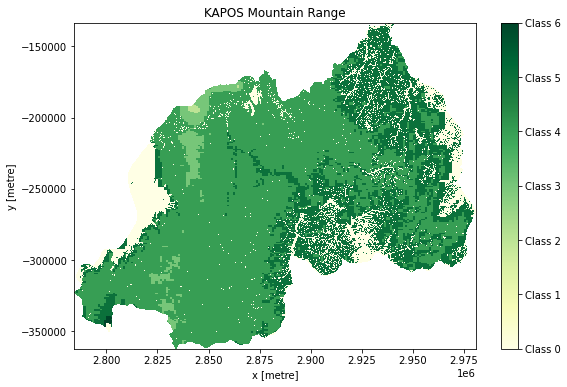

In [17]:
kap = ds["kapo_class"].where(mask).plot(size=6, add_colorbar=False, cmap="YlGn")
kap_c = plt.colorbar(kap)
kap_c.set_ticks(classess)
kap_c.set_ticklabels(class_label)
plt.title("KAPOS Mountain Range")
plt.savefig(f"results/kapos_{country}")
plt.show()

## Loading ESA Climate Change Initiative Land Cover dataset at 300m resolution 

In [18]:
# load the data.
ds_cci = dc.load(product="cci_landcover",
                 time=time,
                 measurements="classification",
                 resolution=(-300, 300),
                 **query)

# Mask the dataset to the country polygon.
mask = xr_rasterize(africa_data[africa_data["COUNTRY"] == country], ds_cci)
ds_cci = ds_cci.where(mask)

### Plotting ESA CCI Land Cover classification

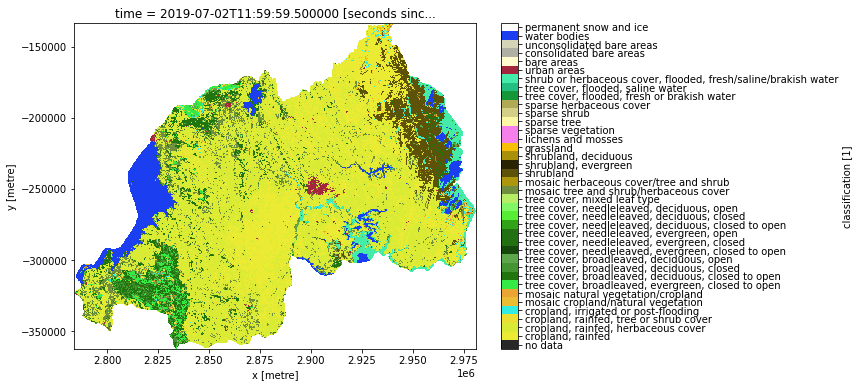

In [19]:
plot_lulc(ds_cci["classification"].squeeze(), product="CCI", size=6)

## Reclassify CCI land Cover to IPCC Land Cover Classes

In [20]:
ipcc_classess = ['Forest', 'Cropland', 'Grassland', 'Wetland', 'Other land', 'Settlement']
ipcc_classess_num = [1, 2, 3, 4, 5, 6]

ds_clas = ds_cci['classification']
#IPCC Classification
forest = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
cropland = [10, 11, 12, 20, 30, 110]
grassland = [40, 120, 121, 122, 130, 140]
wetland = [160, 170, 180]
otherland = [150, 151, 152, 153, 200, 201, 202, 210, 220]
settlement = [190]

ipcc_condition = [ds_clas.isin(forest),
                  ds_clas.isin(cropland),
                  ds_clas.isin(grassland),
                  ds_clas.isin(wetland),
                  ds_clas.isin(otherland),
                  ds_clas.isin(settlement)]

ds_cci["ipcc_classification"] = xr.DataArray(np.select(ipcc_condition, ipcc_classess_num),
                                             coords={"time": ds_cci.time, "y": ds_cci.y, "x": ds_cci.x},
                                             dims=["time", "y", "x"]).astype("int8")

### Plotting IPCC Classification

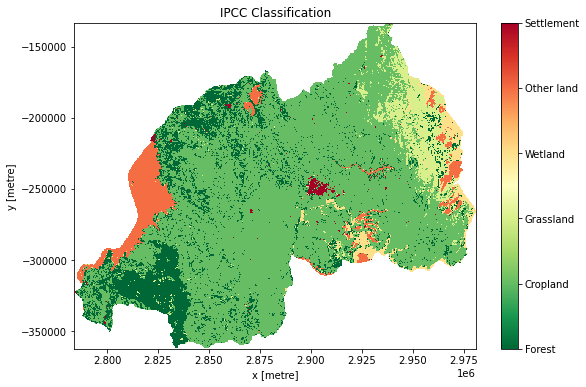

In [21]:
clas = ds_cci["ipcc_classification"].where(mask).plot(add_colorbar=False, size=6, cmap="RdYlGn_r")
clasp = plt.colorbar(clas)
clasp.set_ticks(ipcc_classess_num)
clasp.set_ticklabels(ipcc_classess)
plt.title("IPCC Classification")
plt.savefig(f"results/IPCC_{country}")
plt.show()

## Reclassify IPCC Classification to Green and Non Green Classes

In [22]:
gng_classess = ["Green", "Non Green"]
gng_classess_num = [1, 2]
recl_condition = [ds_cci["ipcc_classification"].isin([1, 2, 3, 4]),
    ds_cci["ipcc_classification"].isin([5, 6])]

ds_cci["green_non_green"] = xr.DataArray(np.select(recl_condition, gng_classess_num),
                                         coords={"time": ds_cci.time, "y": ds_cci.y, "x": ds_cci.x},
                                         dims=["time", "y", "x"]).astype("int8")

### Plotting Green/Non Green Classification

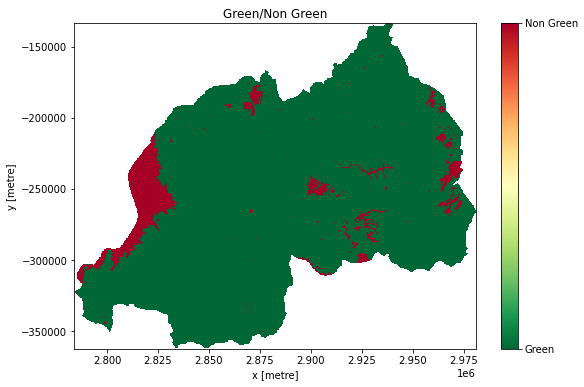

In [23]:
gng = ds_cci["green_non_green"].where(mask).plot(add_colorbar=False, size=6, cmap="RdYlGn_r")

gngp = plt.colorbar(gng)
gngp.set_ticks(gng_classess_num)
gngp.set_ticklabels(gng_classess)
plt.savefig(f"results/Green_Non_Green_{country}")
plt.title("Green/Non Green")
plt.show()

## Downsampling dem_strm dataset at 30m to 300m resolution

In [24]:
ds = (xr_reproject(src=ds, geobox=ds_cci.geobox)).squeeze()

## Pixel Area Conversion

In [25]:
pixel_length = 300  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

## Calculating the Mountain Green Cover Index (MGCI)

<img align="center" src="../../Supplementary_data/MGCI/formulae.png" width=600>

In [26]:
# Total Mountain Area = total area (Km2) of mountains. In both the numerator and
# denominator, Mountain is defined according to Kapos et al. in 2000
total_mountain_area = ds["kapo_class"].where(ds["kapo_class"] != 0).sum(dim=["x", "y"]) * area_per_pixel
mgci = {}
mountain_indices = [y[0] for y in ds.groupby("kapo_class")]
# Mountain Green Cover Area = sum of mountain area (Km2) covered by cropland,
# grassland, forestland, shrubland, and wetland, as defined based on the IPCC classification;
Kapos_filter = (ds["kapo_class"].where(ds_cci["ipcc_classification"].isin([1, 2, 3, 4]), np.nan)).astype("int8")

for mountain_index in mountain_indices:
    # Mountain Green Cover Area (Numerator)
    numerator = Kapos_filter.where(Kapos_filter == mountain_index).sum(dim=["x", "y"]) * area_per_pixel
    # (MGCI)
    mgci[mountain_index] = numerator.values / total_mountain_area.values

result = pd.DataFrame.from_dict(mgci, orient="index", columns=[time])

### Plotting Mountain Green Cover Index

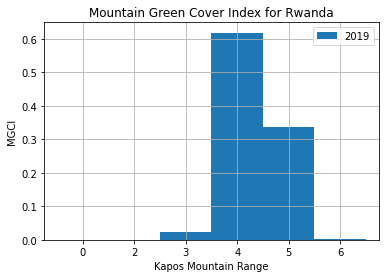

In [27]:
result.plot(kind="bar", width=1)
plt.title(f"Mountain Green Cover Index for {country}")
plt.xlabel("Kapos Mountain Range")
plt.ylabel("MGCI")
plt.xticks(rotation=0)
plt.grid()
plt.savefig(f"results/MGCI_{country}")
plt.show()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [28]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [29]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-06-23'